In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import copy
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import os
import glob
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CIS5810/Final_Project

/content/drive/MyDrive/CIS5810/Final_Project


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [ ]:
# Split a whole video into image frames
def generateFrame(second, stamp):
    video_capture.set(cv2.CAP_PROP_POS_MSEC, 1000 * second)
    isFrame, IMG = video_capture.read()
    if isFrame:
      cv2.imwrite(src_video_frames_dir+str(stamp)+".jpg",IMG)
    return isFrame

In [ ]:
# Set source data dir
src_video_dir = 'videos/source_videos/sample_miami.mp4'
src_video_frames_dir = "videos/source_frames/"

video_capture = cv2.VideoCapture(src_video_dir)

time_stamp = 0
stamp = 1
fps = 30
frmR = 1/fps
# Write video into frames
newFrameGenerated = generateFrame(time_stamp, stamp)
while newFrameGenerated:
  time_stamp = round(time_stamp+frmR, 2)
  newFrameGenerated = generateFrame(time_stamp, stamp)
  stamp += 1

## **Code for image NST:**

In [ ]:
# Output image height
output_h = 700

# Epoch number
nr_epoch = 1000

# Style and content loss weights
cont_w = 8e-4
style_w = 8e-1

# Layer w.r.t. content loss
layer_cont = "block5_conv2" # "block2_conv2"

# Layers w.r.t. content loss
layers_style = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1",]

def compute_output_size(path_img, output_h):
    img_w, img_h = keras.preprocessing.image.load_img(path_img).size
    return output_h, int(output_h*img_w/img_h)

def construct_transfer_model():
    # VGG19 plus pre-trained ImageNet parameters
    transfer_model = vgg19.VGG19(weights='imagenet', include_top=False)
    # Assign each layer a dictonary between name and output
    layered_output = dict([(this_layer.name, this_layer.output) for this_layer in transfer_model.layers])
    return keras.Model(inputs=transfer_model.inputs, outputs=layered_output)

def optimizer_setup():
    # Set up Adam optimizer with exponential decay
    optimizer = keras.optimizers.Adam( keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=8.0, decay_steps=445, decay_rate=0.98 ) )
    return optimizer

def image_preprocessing(path_img, output_h, output_w):
    IMG = keras.preprocessing.image.load_img(path_img, target_size = (output_h, output_w))
    return tf.convert_to_tensor(vgg19.preprocess_input(np.expand_dims(keras.preprocessing.image.img_to_array(IMG), axis = 0)))


# Squared-error loss for content features
def content_loss_calculation(feature_cont, feature_combined):
    return 0.5*tf.reduce_sum(tf.square(feature_combined[layer_cont]-feature_cont[layer_cont]))



def loss_calculation(transfer_model, combined_img, feature_cont, feature_style):

    return cont_w*content_loss_calculation(feature_cont,transfer_model(combined_img))+style_w*style_loss_calculation(feature_style,transfer_model(combined_img),combined_img.shape[2]*combined_img.shape[1])

# Squared-error loss for content features
def content_loss_calculation(feature_cont, feature_combined):
    return 0.5*tf.reduce_sum(tf.square(feature_combined[layer_cont]-feature_cont[layer_cont]))


def gramMat(A):
   AA = tf.transpose(A,(2,0,1))
   feat = tf.reshape(AA, (tf.shape(AA)[0], -1))
   return tf.matmul(feat, tf.transpose(feat))

# Style loss based on based on the gram matrix computation of features mapping the style image to the generated image
def style_loss_calculation(feature_style, feature_combined, size):
    loss = 0
    for this_layer in layers_style:
      style_feature_this_layer = feature_style[this_layer][0]
      combined_feature_this_layer = feature_combined[this_layer][0]
      loss += tf.reduce_sum(tf.square(gramMat(style_feature_this_layer)-gramMat(combined_feature_this_layer)))/(4.0*(style_feature_this_layer.shape[2]**2)*(size**2))/len(layers_style)
    return loss

def loss_calculation_consistency(transfer_model, combined_img, feature_cont, feature_style, content_prev_features, content_prev_features2):
    loss_content = content_loss_calculation_consistency(feature_cont, transfer_model(combined_img), content_prev_features, content_prev_features2)

    return cont_w*loss_content+style_w*style_loss_calculation(feature_style,transfer_model(combined_img),combined_img.shape[2]*combined_img.shape[1])

# Squared-error loss for content features with consistency constraint
def content_loss_calculation_consistency(feature_cont, feature_combined, content_prev_features, content_prev_features2):

    return 0.5*0.01*tf.reduce_sum(tf.square(feature_combined[layer_cont]-feature_cont[layer_cont])) + 0.5*0.49*tf.reduce_sum(tf.square(feature_combined[layer_cont]-content_prev_features[layer_cont])) \
        + 0.5*0.5*tf.reduce_sum(tf.square(feature_combined[layer_cont]-content_prev_features2[layer_cont]))



# Tensor to image
def image_output(image, output_h, output_w):
    image = image.numpy().reshape((output_h,output_w,3))
    # Set actual center of image
    image[:, :, 1]+=116.779
    image[:, :, 2]+=123.680
    image[:, :, 0]+=103.939
    return np.clip(image[:,:,::-1],0,255).astype("uint8")


def generate_style_image(IMG, output_h, output_w, img_name):
    keras.preprocessing.image.save_img(img_name, image_output(IMG, output_h, output_w))
    plt.imshow(image_output(IMG, output_h, output_w))
    plt.axis('off')
    plt.show()

80134624/80134624 [==============================] - 3s 0us/step
Epoch number:  499 and current loss:    94994
Epoch number:  999 and current loss:    72055


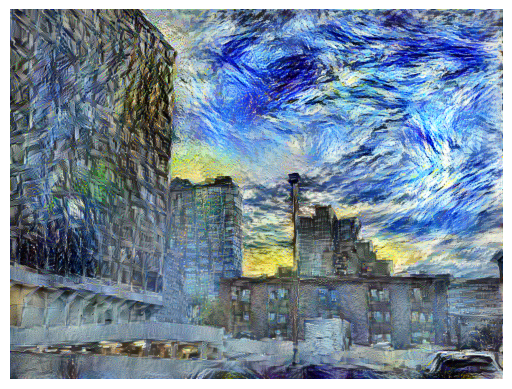

In [ ]:
# Prepare content, stlye images
style_seq = 'star-night'
content_seq='rooftop'
style_path = 'high_res_jpg/'+style_seq+'.jpg'
content_path = 'content_jpg/'+content_seq+'.jpg'

# Output size is the same as the content image
output_h, output_w = compute_output_size(content_path, output_h)

# Image preprocessing to get content and style tensors
content = image_preprocessing(content_path, output_h, output_w)
style = image_preprocessing(style_path, output_h, output_w)

# Initialize generated image randomly
output_image = tf.Variable(tf.random.uniform(style.shape, dtype=tf.dtypes.float32))

# Establish the model and optimizer
transfer_model = construct_transfer_model()
optimizer = optimizer_setup()
# print(transfer_model.summary())

feature_cont = transfer_model(content)
feature_style = transfer_model(style)

# Optimization process
for epoch in range(nr_epoch):
  with tf.GradientTape() as grad_tape:
    loss = loss_calculation(transfer_model, output_image, feature_cont, feature_style)
    gradients = grad_tape.gradient(loss, output_image)
    optimizer.apply_gradients([(gradients, output_image)])

    if (epoch+1) % 500 == 0:
      print("Epoch number: %4d and current loss: %8.f" % (epoch, loss))

IMG_name = "result/NST_"+style_seq+"_"+content_seq+".jpg"
generate_style_image(output_image, output_h, output_w, IMG_name)

Epoch number:  499 and current loss:    39100
Epoch number:  999 and current loss:    32547


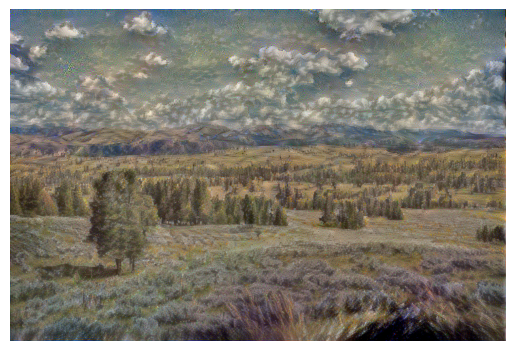

In [ ]:
# Prepare content, stlye images
style_seq = 'shipwreck'
content_seq='field'
style_path = 'high_res_jpg/'+style_seq+'.jpg'
content_path = 'content_jpg/'+content_seq+'.jpg'

# Output size is the same as the content image
output_h, output_w = compute_output_size(content_path, output_h)

# Image preprocessing to get content and style tensors
content = image_preprocessing(content_path, output_h, output_w)
style = image_preprocessing(style_path, output_h, output_w)

# Initialize generated image randomly
output_image = tf.Variable(tf.random.uniform(style.shape, dtype=tf.dtypes.float32))

# Establish the model and optimizer
transfer_model = construct_transfer_model()
optimizer = optimizer_setup()
# print(transfer_model.summary())

feature_cont = transfer_model(content)
feature_style = transfer_model(style)

# Optimization process
for epoch in range(nr_epoch):
  with tf.GradientTape() as grad_tape:
    loss = loss_calculation(transfer_model, output_image, feature_cont, feature_style)
    gradients = grad_tape.gradient(loss, output_image)
    optimizer.apply_gradients([(gradients, output_image)])

    if (epoch+1) % 500 == 0:
      print("Epoch number: %4d and current loss: %8.f" % (epoch, loss))

IMG_name = "result/NST_"+style_seq+"_"+content_seq+".jpg"
generate_style_image(output_image, output_h, output_w, IMG_name)

## **Code for video (consistency-based) NST:**

In [ ]:
# List all files in the specified directory
entries = os.listdir('videos/source_frames/')
# Count the number of files
file_count = sum(os.path.isfile(os.path.join('videos/source_frames/', entry)) for entry in entries)
print(f'There are {file_count} video frames in the folder.')

There are 373 video frames in the folder.


In [ ]:
cont_w = 8e-3
output_h = 700
nr_epoch = 800
style_seq = 'star-night'
style_path = 'van_gogh_jpg/'+style_seq+'.jpg'
# style_image_path = 'van_gogh_jpg/00159.jpg'
first_frame = True
for nr_img in range(1, 40+1):

  # Prepare content, stlye images
  content_path = 'videos/source_frames/'+str(4*nr_img)+'.jpg'

  if nr_img >1:
    content_prev_image_path = 'videos/source_frames/'+str(4*nr_img-1)+'.jpg'
    content_prev_image_path2 = 'videos/source_frames/'+str(4*nr_img-2)+'.jpg'
  else:
    content_prev_image_path = 'videos/source_frames/1.jpg'
    content_prev_image_path2 = 'videos/source_frames/2.jpg'

  # Output size is the same as the content image
  output_h, output_w = compute_output_size(content_path, output_h)

  # Image preprocessing to get content and style tensors
  content = image_preprocessing(content_path, output_h, output_w)
  style = image_preprocessing(style_path, output_h, output_w)

  content_prev_tensor = image_preprocessing(content_prev_image_path, output_h, output_w)
  content_prev_tensor2 = image_preprocessing(content_prev_image_path2, output_h, output_w)

  # Initialize generated image randomly
  if first_frame:
    output_image = tf.Variable(tf.random.uniform(style.shape, dtype=tf.dtypes.float32))

  # Establish the model and optimizer
  transfer_model = construct_transfer_model()
  optimizer = optimizer_setup()
  feature_cont = transfer_model(content)
  feature_style = transfer_model(style)

  content_prev_features = transfer_model(content_prev_tensor)
  content_prev_features2 = transfer_model(content_prev_tensor2)

  # Optimization process
  for epoch in range(nr_epoch):
    with tf.GradientTape() as grad_tape:

      loss = loss_calculation_consistency(transfer_model, output_image, feature_cont, feature_style, content_prev_features, content_prev_features2)
      gradients = grad_tape.gradient(loss, output_image)
      optimizer.apply_gradients([(gradients, output_image)])

      if (epoch+1) % 400 == 0:
        print("nr_img: %4d Epoch number: %4d and current loss: %8.f" % (nr_img, epoch, loss))

  if nr_img<10:
    IMG_name = "videos/output_frames/0%d.jpg" % (nr_img)
  else:
    IMG_name = "videos/output_frames/%d.jpg" % (nr_img)
  generate_style_image(output_image, output_h, output_w, IMG_name)
  first_frame = False


80134624/80134624 [==============================] - 4s 0us/step
nr_img:    1 Epoch number:  399 and current loss:   619307
nr_img:    1 Epoch number:  799 and current loss:   549148
nr_img:    2 Epoch number:  399 and current loss:   638502
nr_img:    2 Epoch number:  799 and current loss:   641163
nr_img:    3 Epoch number:  399 and current loss:   645246
nr_img:    3 Epoch number:  799 and current loss:   589252
nr_img:    4 Epoch number:  399 and current loss:   680493
nr_img:    4 Epoch number:  799 and current loss:   753858
nr_img:    5 Epoch number:  399 and current loss:   708104
nr_img:    5 Epoch number:  799 and current loss:   654337
nr_img:    6 Epoch number:  399 and current loss:   734081
nr_img:    6 Epoch number:  799 and current loss:   694264
nr_img:    7 Epoch number:  399 and current loss:   780689
nr_img:    7 Epoch number:  799 and current loss:   718544
nr_img:    8 Epoch number:  399 and current loss:   700856
nr_img:    8 Epoch number:  799 and current loss: 

In [ ]:
# Set the folder path and the output video path
folder_path = 'videos/output_frames/'
video_path = 'videos/NST_miami_star-night_new3.mp4'

# Get list of all image files in folder
images = [img for img in os.listdir(folder_path) if img.endswith(".jpg")]
# Sort images
images.sort()

# Get the width and height from the first image
image_path = os.path.join(folder_path, images[0])
frame = cv2.imread(image_path)
height, width, layers = frame.shape

# Define the codec and create the VideoWriter obj
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID' 'mp4v'
video = cv2.VideoWriter(video_path, fourcc, 8, (width, height))

# Write out frames to video
for image in images:
    image_path = os.path.join(folder_path, image)
    frame = cv2.imread(image_path)
    video.write(frame)

# Release the writer
video.release()